In [1]:
import tensorflow as tf

from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np

# Normal distribution

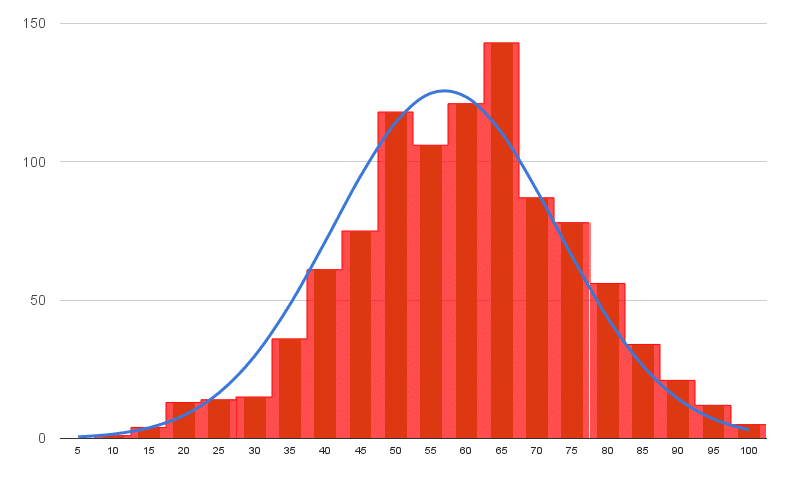

In [13]:
Image('img/NormalDistribution.jpg', width=500)

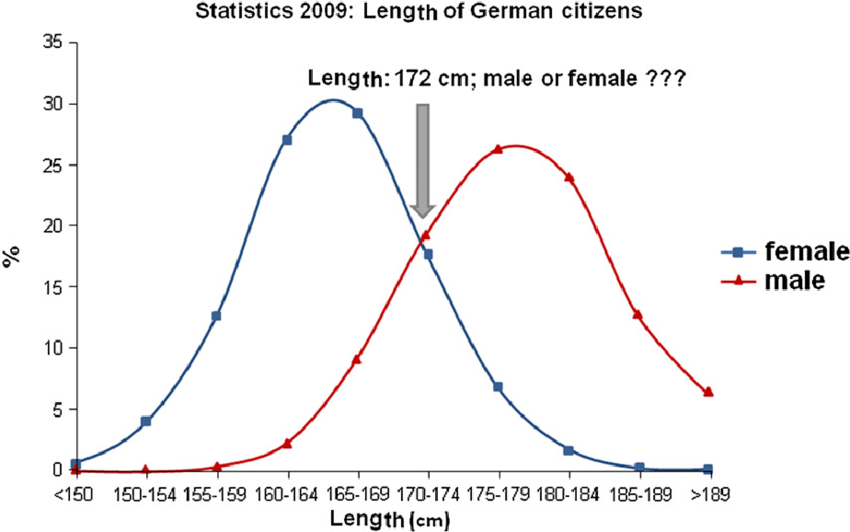

In [14]:
Image('img/NormalDistribution_height.jpg', width=500)

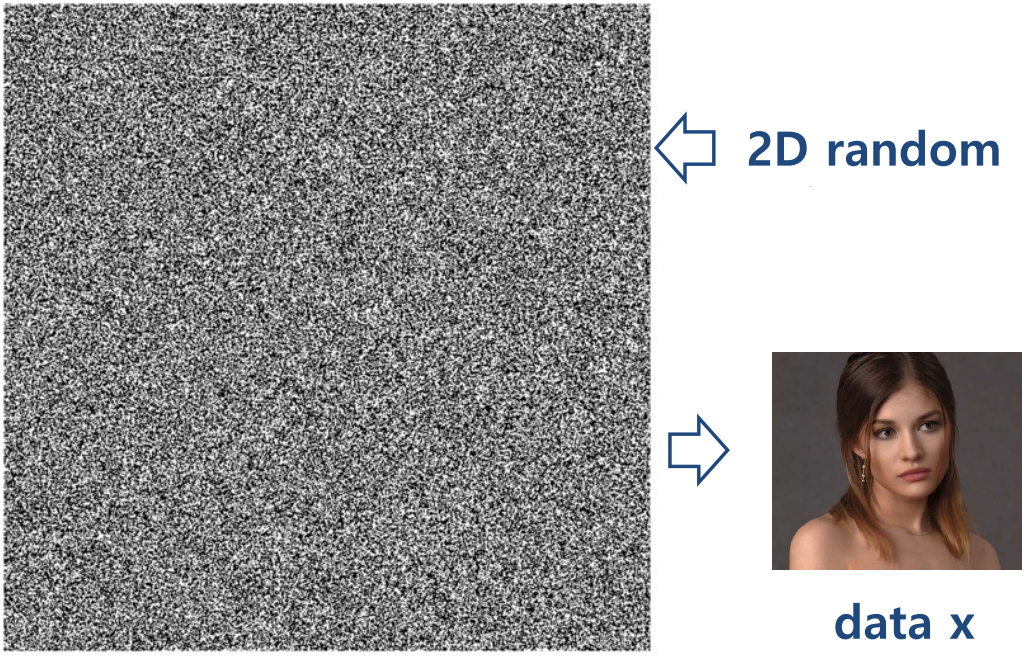

In [15]:
Image('img/randomNoise.jpg', width=500)

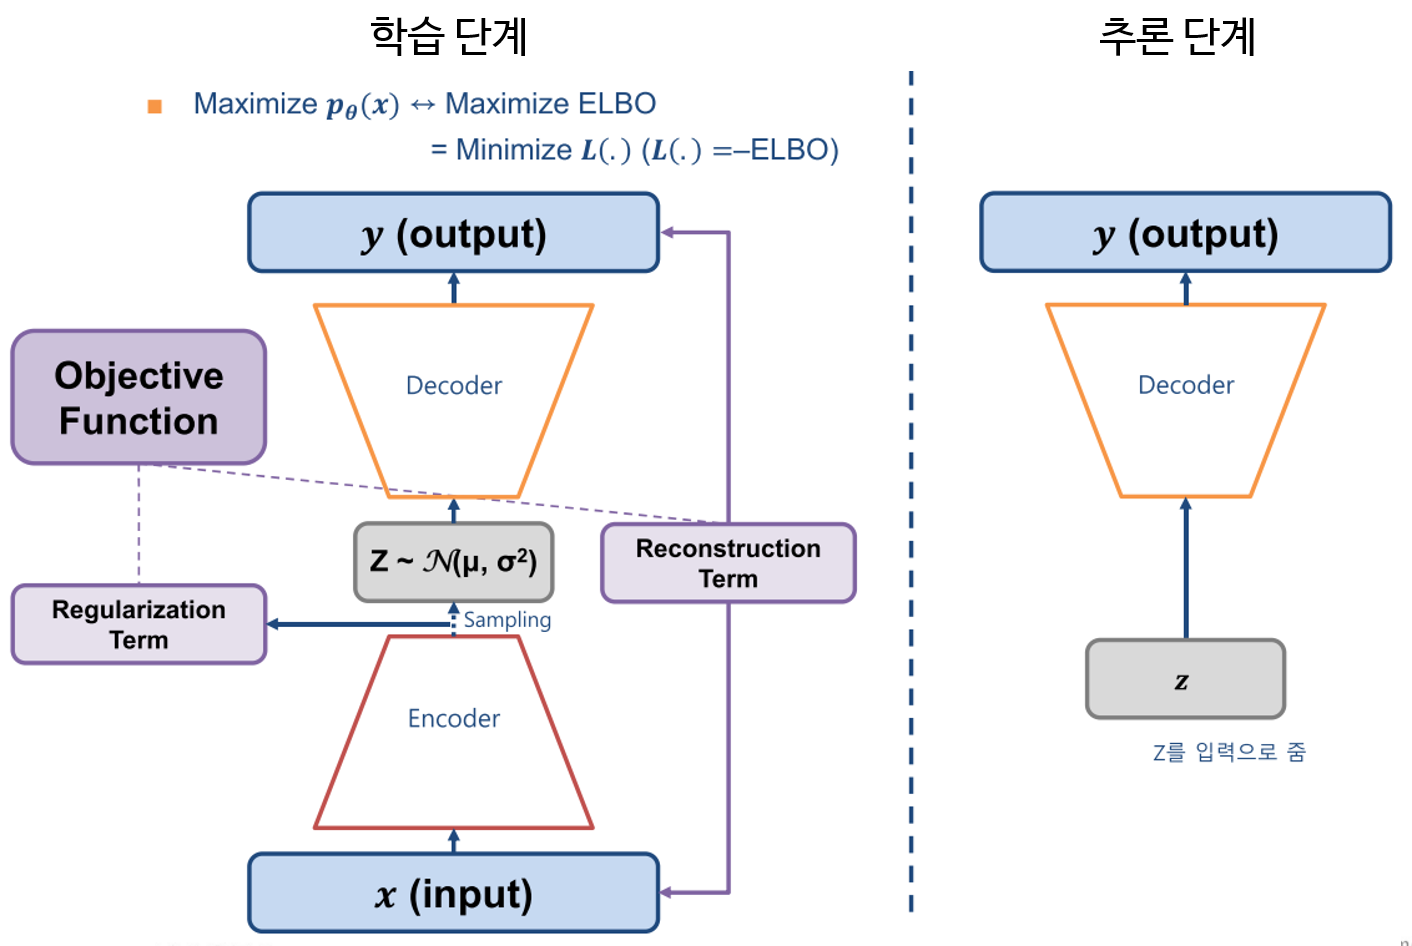

In [16]:
Image('img/VAE.jpg', width=500)

# Sampling from Z-distribution

In [17]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build encoder

In [18]:
latent_dim = 2

encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

## Build encoder

In [19]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

# VAE의 구현

In [20]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [21]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

## Data load

In [25]:
x_train[0].shape

(28, 28, 1)

In [23]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

In [24]:
vae.fit(x_train, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 71s 144ms/step - loss: 262.3715 - reconstruction_loss: 213.1236 - kl_loss: 2.7140
Epoch 2/5
469/469 [==============================] - 67s 143ms/step - loss: 191.7955 - reconstruction_loss: 187.1030 - kl_loss: 3.2852
Epoch 3/5
469/469 [==============================] - 60s 128ms/step - loss: 186.8075 - reconstruction_loss: 181.3981 - kl_loss: 3.5397
Epoch 4/5
469/469 [==============================] - 59s 126ms/step - loss: 174.8220 - reconstruction_loss: 165.9270 - kl_loss: 5.4120
Epoch 5/5
469/469 [==============================] - 61s 130ms/step - loss: 165.1705 - reconstruction_loss: 158.3969 - kl_loss: 5.8558


# Results

In [26]:
encoded_img = encoder(x_test[:5])

In [27]:
decoded_img = decoder(encoded_img[2])

In [28]:
decoded_img.shape

TensorShape([5, 28, 28, 1])

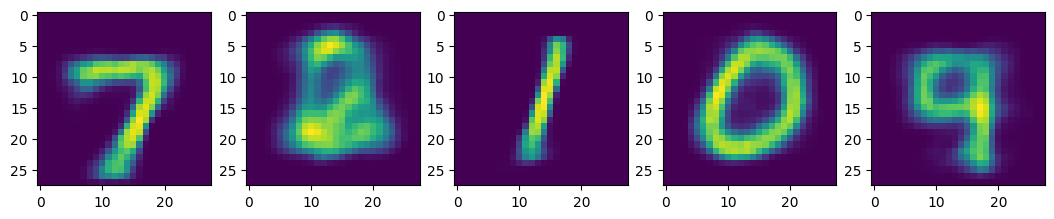

In [29]:
fig = plt.figure(figsize=(13, 3))

for i in range(5):
    fig.add_subplot(1, 5, i+1) # row, column, n번째 image
    plt.imshow(decoded_img[i]/255, interpolation='nearest')

In [30]:
encoded_img[2]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 2.04707   ,  2.7065365 ],
       [ 0.60928786, -0.29128912],
       [ 2.871784  , -1.3673832 ],
       [ 0.16506314, -0.26398575],
       [ 1.1004045 ,  1.4810119 ]], dtype=float32)>

1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 54ms/step


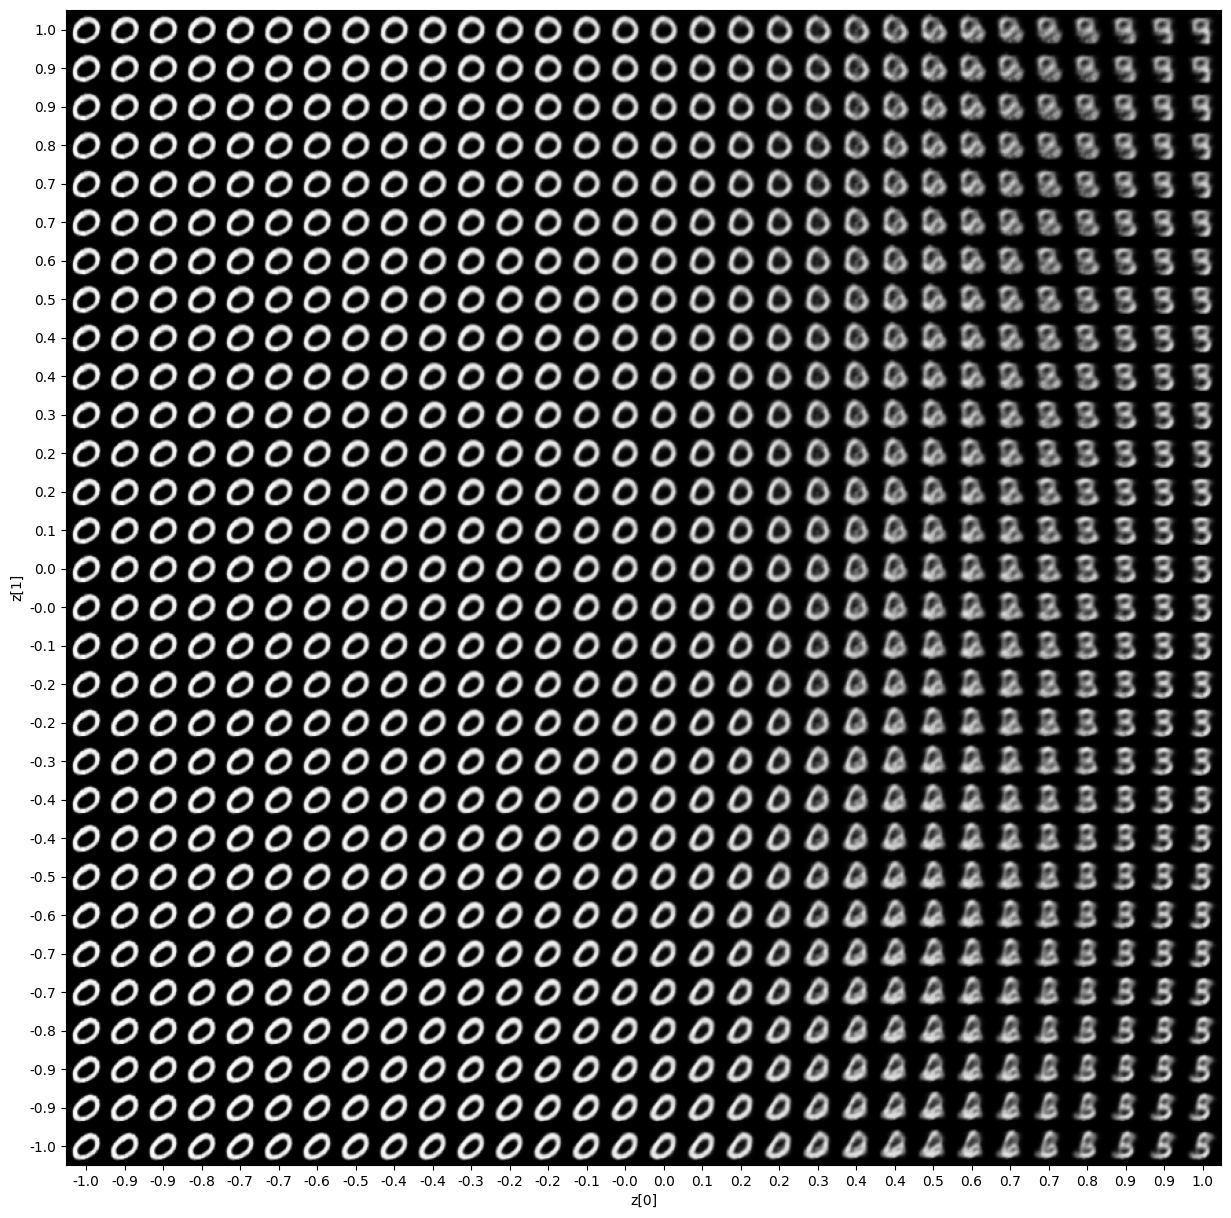

In [31]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

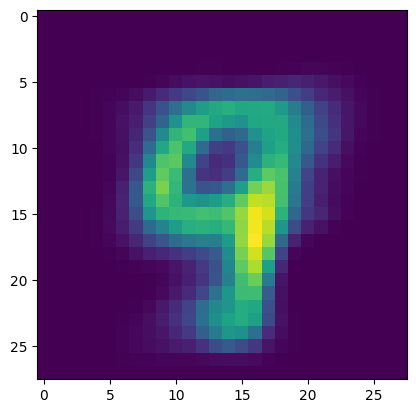

In [32]:
z_mean = 1.5
z_var = 0.7
decoded_img = decoder(np.array([[z_mean, z_var]]))
plt.imshow(decoded_img[0]/255, interpolation='nearest')

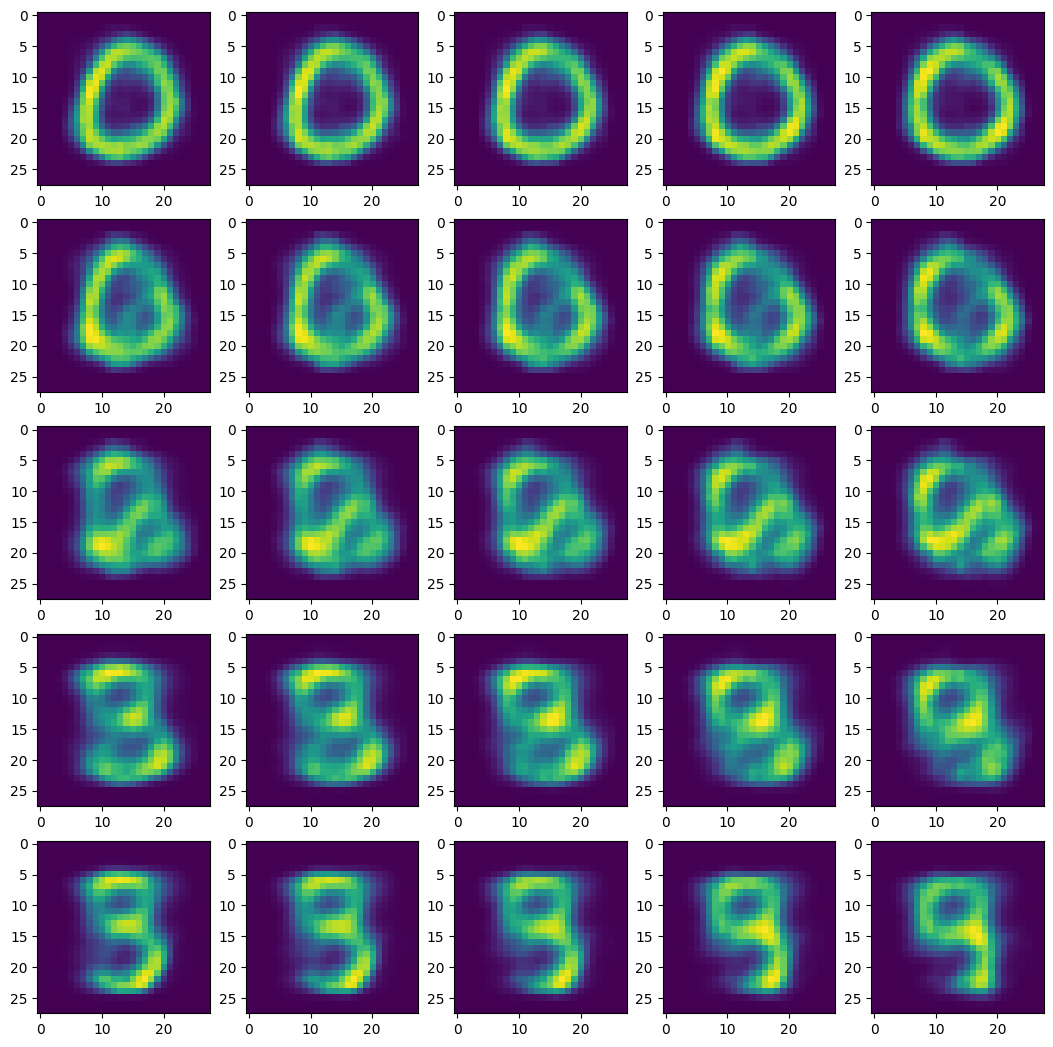

In [33]:
z_mean = 1.5
z_var = 0.7

fig = plt.figure(figsize=(13, 13))

i=1
for z_mean in [0.2, 0.4, 0.6, 0.8, 1]:
    for z_var in [0.2, 0.4, 0.6, 0.8, 1]:
        decoded_img = decoder(np.array([[z_mean, z_var]]))
        
        fig.add_subplot(5, 5, i) # row, column, n번째 image
        plt.imshow(decoded_img[0]/255, interpolation='nearest')
        i+=1